In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

Using plaidml.keras.backend backend.


In [2]:
import cv2, os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from glob import glob
from keras.preprocessing import image
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [4]:
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
path = 'dataset/dogs-vs-cats/train'

In [6]:
ROW, COL = 96, 96

dogs, cats = [], []
y_dogs, y_cats = [], []

In [7]:
dog_path = os.path.join(path, 'dog.*')
for dog_img in glob(dog_path):
    dog = cv2.imread(dog_img)
    dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
    dog = cv2.resize(dog, (ROW, COL))
    dog = image.img_to_array(dog)
    dogs.append(dog)
print('All dog images loaded')

All dog images loaded


In [8]:
cat_path = os.path.join(path, 'cat.*')
for cat_img in glob(cat_path):
    cat = cv2.imread(cat_img)
    cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
    cat = cv2.resize(cat, (ROW, COL))
    cat = image.img_to_array(cat)
    cats.append(cat)
print('All cat images loaded')

All cat images loaded


In [9]:
def shows(label):
    plt.figure(figsize=(12, 8))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.array_to_img(random.choice(label))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.axis('off')

    plt.show()

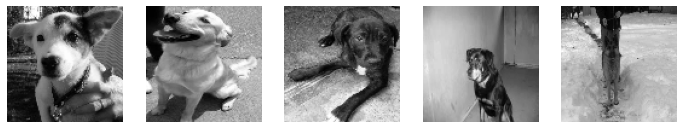

In [10]:
shows(dogs)

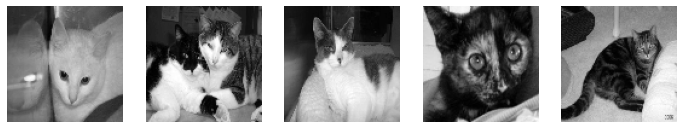

In [11]:
shows(cats)

In [12]:
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]

In [13]:
dogs = np.asarray(dogs).astype('float32') / 255
cats = np.asarray(cats).astype('float32') / 255
y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')

In [14]:
dogs.shape, y_dogs.shape

((12500, 96, 96, 1), (12500,))

In [15]:
x_data = np.concatenate((dogs, cats), axis = 0)
y_data = np.concatenate((y_dogs, y_cats), axis = 0)

In [16]:
y_data = tf.keras.utils.to_categorical(y_data, 2)

In [17]:
x_train, x_test, y_train, t_test = train_test_split(x_data, y_data, test_size=0.2, random_state = seed)

In [18]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(ROW, COL, 1),  activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(2, activation='softmax')
])

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
__________

In [20]:
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Nadam(),
             metrics = ['accuracy'])

In [21]:
modelpath = "../model/dogsvscats-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = keras.callbacks.ModelCheckpoint(modelpath,verbose=1, save_best_only=True)
early_stopping_cv = keras.callbacks.EarlyStopping(patience=50)

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[checkpointer, early_stopping_cv])

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 68s 4ms/step - loss: 0.7202 - acc: 0.5200 - val_loss: 0.6937 - val_acc: 0.4925

Epoch 00001: val_loss improved from inf to 0.69375, saving model to ../model/dogsvscats-01-0.6937.hdf5
Epoch 2/100
16000/16000 [==============================] - 60s 4ms/step - loss: 0.6936 - acc: 0.5028 - val_loss: 0.6930 - val_acc: 0.5075

Epoch 00002: val_loss improved from 0.69375 to 0.69304, saving model to ../model/dogsvscats-02-0.6930.hdf5
Epoch 3/100
16000/16000 [==============================] - 59s 4ms/step - loss: 0.6935 - acc: 0.5022 - val_loss: 0.6933 - val_acc: 0.4925

Epoch 00003: val_loss did not improve from 0.69304
Epoch 4/100
16000/16000 [==============================] - 59s 4ms/step - loss: 0.6933 - acc: 0.4986 - val_loss: 0.6930 - val_acc: 0.5075

Epoch 00004: val_loss did not improve from 0.69304
Epoch 5/100
16000/16000 [==============================] - 60s 4ms/step - loss: 0.6